In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
from keystroke_module import *

In [ ]:
# TO DO: kontrola bledow np. w konstruktorze klasy -?
# zalozenie minimalnej dlugosci: 100 czy 150? (bo wynika ze w ciagu 6min z 1.datasetu najmniej to 107 i 117 po filtracji, reszta co najmniej 150 kikniec, srednio na osobe wychodzi 600)

## Read data - (1. dataset)

d:\studia_mgrEIM\master_diploma\repo\masterdiploma\keystroke_module.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.drop(columns=['file_2'], inplace=True)


Patients with PD:  60
Patients without PD:  56


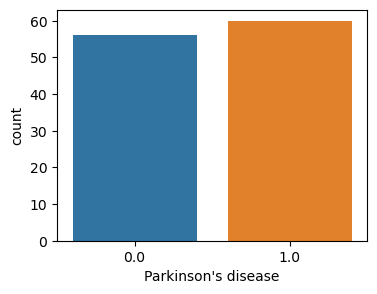

In [2]:
filename1 = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv'
filename2 = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv'
path = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/all/'

data1 = nqDataset(filename1, filename2)
data1.show_stats()

In [10]:
data1.prepare_dataset(path, feature_extract=2)
print(data1.features.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
(116, 22)


In [12]:
# tests
a = np.count_nonzero(np.isnan(data1.features))
print(a)
col_mean = np.nanmean(data1.features, axis=0)

inds = np.where(np.isnan(data1.features))
data1.features[inds] = np.take(col_mean, inds[1])
b = np.count_nonzero(np.isnan(data1.features))
print(b)

2
0


In [7]:
('  KNN')
cross_validation(data1.features, data1.ground_truth, train_func=train_kNN_model)

Number of fold:  1
{'0.0': {'precision': 0.5625, 'recall': 0.9, 'f1-score': 0.6923076923076923, 'support': 10}, '1.0': {'precision': 0.875, 'recall': 0.5, 'f1-score': 0.6363636363636364, 'support': 14}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.71875, 'recall': 0.7, 'f1-score': 0.6643356643356644, 'support': 24}, 'weighted avg': {'precision': 0.7447916666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6596736596736597, 'support': 24}}
Number of fold:  2
{'0.0': {'precision': 0.4, 'recall': 0.6666666666666666, 'f1-score': 0.5, 'support': 6}, '1.0': {'precision': 0.8461538461538461, 'recall': 0.6470588235294118, 'f1-score': 0.7333333333333334, 'support': 17}, 'accuracy': 0.6521739130434783, 'macro avg': {'precision': 0.6230769230769231, 'recall': 0.6568627450980392, 'f1-score': 0.6166666666666667, 'support': 23}, 'weighted avg': {'precision': 0.7297658862876254, 'recall': 0.6521739130434783, 'f1-score': 0.6724637681159421, 'support': 23}}
Number of fold:  3
{'0.0':

In [13]:
('  KNN')
cross_validation(data1.features, data1.ground_truth, train_func=train_kNN_model)

Number of fold:  1
{'0.0': {'precision': 0.5833333333333334, 'recall': 0.7, 'f1-score': 0.6363636363636365, 'support': 10}, '1.0': {'precision': 0.75, 'recall': 0.6428571428571429, 'f1-score': 0.6923076923076924, 'support': 14}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.6666666666666667, 'recall': 0.6714285714285715, 'f1-score': 0.6643356643356644, 'support': 24}, 'weighted avg': {'precision': 0.6805555555555557, 'recall': 0.6666666666666666, 'f1-score': 0.6689976689976692, 'support': 24}}
Number of fold:  2
{'0.0': {'precision': 0.7142857142857143, 'recall': 0.3333333333333333, 'f1-score': 0.4545454545454545, 'support': 15}, '1.0': {'precision': 0.375, 'recall': 0.75, 'f1-score': 0.5, 'support': 8}, 'accuracy': 0.4782608695652174, 'macro avg': {'precision': 0.5446428571428572, 'recall': 0.5416666666666666, 'f1-score': 0.47727272727272724, 'support': 23}, 'weighted avg': {'precision': 0.5962732919254659, 'recall': 0.4782608695652174, 'f1-score': 0.4703557312252964, '

In [8]:
('  SVM')
cross_validation(data1.features, data1.ground_truth, train_func=train_SVM_model)

Number of fold:  1
{'0.0': {'precision': 0.6428571428571429, 'recall': 0.9, 'f1-score': 0.75, 'support': 10}, '1.0': {'precision': 0.9, 'recall': 0.6428571428571429, 'f1-score': 0.75, 'support': 14}, 'accuracy': 0.75, 'macro avg': {'precision': 0.7714285714285715, 'recall': 0.7714285714285715, 'f1-score': 0.75, 'support': 24}, 'weighted avg': {'precision': 0.7928571428571428, 'recall': 0.75, 'f1-score': 0.75, 'support': 24}}
Number of fold:  2
{'0.0': {'precision': 0.7272727272727273, 'recall': 0.8, 'f1-score': 0.761904761904762, 'support': 10}, '1.0': {'precision': 0.8333333333333334, 'recall': 0.7692307692307693, 'f1-score': 0.8, 'support': 13}, 'accuracy': 0.782608695652174, 'macro avg': {'precision': 0.7803030303030303, 'recall': 0.7846153846153847, 'f1-score': 0.7809523809523811, 'support': 23}, 'weighted avg': {'precision': 0.7872200263504613, 'recall': 0.782608695652174, 'f1-score': 0.7834368530020704, 'support': 23}}
Number of fold:  3
{'0.0': {'precision': 0.7272727272727273, 

In [20]:
('  SVM')
cross_validation(data1.features, data1.ground_truth, train_func=train_SVM_model)

Number of fold:  1
{'0.0': {'precision': 0.6153846153846154, 'recall': 1.0, 'f1-score': 0.761904761904762, 'support': 8}, '1.0': {'precision': 1.0, 'recall': 0.6875, 'f1-score': 0.8148148148148148, 'support': 16}, 'accuracy': 0.7916666666666666, 'macro avg': {'precision': 0.8076923076923077, 'recall': 0.84375, 'f1-score': 0.7883597883597884, 'support': 24}, 'weighted avg': {'precision': 0.8717948717948718, 'recall': 0.7916666666666666, 'f1-score': 0.7971781305114639, 'support': 24}}
Number of fold:  2
{'0.0': {'precision': 0.6666666666666666, 'recall': 0.46153846153846156, 'f1-score': 0.5454545454545455, 'support': 13}, '1.0': {'precision': 0.5, 'recall': 0.7, 'f1-score': 0.5833333333333334, 'support': 10}, 'accuracy': 0.5652173913043478, 'macro avg': {'precision': 0.5833333333333333, 'recall': 0.5807692307692307, 'f1-score': 0.5643939393939394, 'support': 23}, 'weighted avg': {'precision': 0.5942028985507246, 'recall': 0.5652173913043478, 'f1-score': 0.5619235836627141, 'support': 23}

In [9]:
('  MLP')
cross_validation(data1.features, data1.ground_truth, train_func=train_MLP_model)

Number of fold:  1


d:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


{'0.0': {'precision': 0.7142857142857143, 'recall': 0.8333333333333334, 'f1-score': 0.7692307692307692, 'support': 12}, '1.0': {'precision': 0.8, 'recall': 0.6666666666666666, 'f1-score': 0.7272727272727272, 'support': 12}, 'accuracy': 0.75, 'macro avg': {'precision': 0.7571428571428571, 'recall': 0.75, 'f1-score': 0.7482517482517481, 'support': 24}, 'weighted avg': {'precision': 0.7571428571428571, 'recall': 0.75, 'f1-score': 0.7482517482517482, 'support': 24}}
Number of fold:  2
{'0.0': {'precision': 0.5833333333333334, 'recall': 0.5833333333333334, 'f1-score': 0.5833333333333334, 'support': 12}, '1.0': {'precision': 0.5454545454545454, 'recall': 0.5454545454545454, 'f1-score': 0.5454545454545454, 'support': 11}, 'accuracy': 0.5652173913043478, 'macro avg': {'precision': 0.5643939393939394, 'recall': 0.5643939393939394, 'f1-score': 0.5643939393939394, 'support': 23}, 'weighted avg': {'precision': 0.5652173913043478, 'recall': 0.5652173913043478, 'f1-score': 0.5652173913043478, 'suppo

d:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
('  MLP')
cross_validation(data1.features, data1.ground_truth, train_func=train_MLP_model)

Number of fold:  1


d:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

{'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}, '1.0': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 12}, 'accuracy': 0.5, 'macro avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 24}, 'weighted avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 24}}
Number of fold:  2
{'0.0': {'precision': 0.6521739130434783, 'recall': 1.0, 'f1-score': 0.7894736842105263, 'support': 15}, '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, 'accuracy': 0.6521739130434783, 'macro avg': {'precision': 0.32608695652173914, 'recall': 0.5, 'f1-score': 0.39473684210526316, 'support': 23}, 'weighted avg': {'precision': 0.42533081285444235, 'recall': 0.6521739130434783, 'f1-score': 0.5148741418764302, 'support': 23}}
Number of fold:  3


d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

{'0.0': {'precision': 0.391304347826087, 'recall': 1.0, 'f1-score': 0.5625, 'support': 9}, '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.391304347826087, 'macro avg': {'precision': 0.1956521739130435, 'recall': 0.5, 'f1-score': 0.28125, 'support': 23}, 'weighted avg': {'precision': 0.15311909262759923, 'recall': 0.391304347826087, 'f1-score': 0.22010869565217392, 'support': 23}}
Number of fold:  4
{'0.0': {'precision': 0.34782608695652173, 'recall': 1.0, 'f1-score': 0.5161290322580645, 'support': 8}, '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15}, 'accuracy': 0.34782608695652173, 'macro avg': {'precision': 0.17391304347826086, 'recall': 0.5, 'f1-score': 0.25806451612903225, 'support': 23}, 'weighted avg': {'precision': 0.12098298676748583, 'recall': 0.34782608695652173, 'f1-score': 0.17952314165497896, 'support': 23}}
Number of fold:  5


d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0.0': {'precision': 0.5217391304347826, 'recall': 1.0, 'f1-score': 0.6857142857142856, 'support': 12}, '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11}, 'accuracy': 0.5217391304347826, 'macro avg': {'precision': 0.2608695652173913, 'recall': 0.5, 'f1-score': 0.3428571428571428, 'support': 23}, 'weighted avg': {'precision': 0.2722117202268431, 'recall': 0.5217391304347826, 'f1-score': 0.35776397515527947, 'support': 23}}
Cross Validation Accuracy Scores:  [0.5, 0.65, 0.39, 0.35, 0.52]
Average CV Score:  0.48200000000000004


d:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

## Read data - (2. dataset TAPPY)

In [22]:
class tappyDataset:

    def __init__(self, path1, path2, opt=1):

        # load data
        self.files_list1 = os.listdir(path1)
        self.files_list2 = os.listdir(path2)
        users = [el.split("_")[1].split(".")[0] for el in self.files_list1]
        df = pd.DataFrame(data=users, columns=['pID'])

        if opt == 1:
            with open('reports_23_08.txt', 'r') as f:
                lsID = f.readlines()
            lsID = '|'.join(lsID)
            clean_lsID = lsID.replace('\n', '')
            df.drop(df[df['pID'].str.contains(clean_lsID)].index, inplace=True)
            df.reset_index(inplace=True)

        for i, el in enumerate(df['pID']):
            temp = [x for x in self.files_list2 if x.startswith(el)]
            if len(temp):
                df.loc[[i], 'files'] = pd.Series([temp], index=df.index[[i]])
                with open(path1 + self.files_list1[i], 'r') as f:
                    for line in f:
                        if 'Parkinsons' in line:
                            read_info = line.strip().split(": ")
                            df.loc[[i], 'Parkinsons'] = read_info[1]

        df.dropna(inplace=True)
        df['Parkinsons'] = df['Parkinsons'].map({'True': 1.0, 'False': 0.0})

        self.user_info = df

        self.trainset = None
        self.testset = None
        self.train_ground_truth = None
        self.test_ground_truth = None
        self.features = None
        self.ground_truth = self.user_info['Parkinsons'].to_numpy()
        self.flag_fatal = []

    def show_stats(self):
        print('Patients with PD: ', len(
            self.user_info[self.user_info['Parkinsons'] == 1.0]))
        print('Patients without PD: ', len(
            self.user_info[self.user_info['Parkinsons'] == 0.0]))
        plt.figure(figsize=[4, 3])
        sns.countplot(x='Parkinsons', data=self.user_info)
        plt.xlabel('Parkinson\'s disease')

    # TO DO:
    @staticmethod
    def load_record(filename):
        df = pd.read_csv(filename, delimiter="\t", index_col=False, header=None, names=[
                         'User', 'Date', 'Timestamp', 'Hand', 'holdTime', 'Direction', 'flightTime', 'latencyTime'])

        df.drop(columns=['User'], inplace=True)
        df.drop(columns=['Direction'], inplace=True)

        df[df.columns[-3:]] = df[df.columns[-3:]
                                 ].apply(lambda x: x.lstrip('0') if type(x) == str else x)
        df[df.columns[-3:]
           ] = pd.to_numeric(df[df.columns[-3:]].stack(), errors='coerce').unstack()
        df[df.columns[-3:]] = df[df.columns[-3:]].apply(lambda x: x/1000)

        grouped_data = df.groupby('Date').agg(list)
        grouped_data['Length'] = grouped_data['Timestamp'].apply(len)

        idx = grouped_data['Length'].idxmax()

        ex_rec2 = df[df['Date'] == idx].copy()
        temp = ex_rec2['Timestamp'].apply(lambda x: is_date_parsing(x))
        ex_rec2.drop(ex_rec2[temp == False].index, inplace=True)

        # ex_rec1 = df[df['Date'] == idx].copy()
        # try:
        #     ex_rec1['Hour'] = ex_rec1['Timestamp'].apply(
        #         lambda x: datetime.strptime(x, '%H:%M:%S.%f').hour)
        # except ValueError as ve:
        #     # TO DO: check procedure of format in column, remove wrong values
        #     print('Procedure')
        #     temp = ex_rec1['Timestamp'].apply(lambda x: is_date_parsing(x))
        #     ex_rec1.drop(ex_rec1[temp == False].index, inplace=True)
        #     ex_rec1['Hour'] = ex_rec1['Timestamp'].apply(
        #         lambda x: datetime.strptime(x, '%H:%M:%S.%f').hour)

        # grouped_data = ex_rec1.groupby('Hour').agg(list)
        # grouped_data['Length'] = grouped_data['Date'].apply(len)

        # # jeśli jest odpowiednia liczba znakow
        # if grouped_data['Length'].max() > 100:
        #     idx = grouped_data['Length'].idxmax()
        #     ex_rec2 = ex_rec1[ex_rec1['Hour'] == idx].copy()
        #     ex_rec2.drop('Hour', axis=1, inplace=True)
        #     ex_rec2.reset_index(inplace=True)

        #     ex_rec2['Timestamp'] = ex_rec2['Timestamp'].apply(
        #         lambda x: datetime.strptime(x, '%H:%M:%S.%f'))
        #     ex_rec2['timeLapse'] = count_time_from_0(ex_rec2)
        # else:
        #     print('Not enough keystroke events!  ',
        #           grouped_data['Length'].max())
        #     ex_rec2 = []

        ex_rec2.reset_index(inplace=True)
        ex_rec2['Timestamp'] = ex_rec2['Timestamp'].apply(
            lambda x: datetime.strptime(x, '%H:%M:%S.%f'))
        ex_rec2['timeLapse'] = count_time_from_0(ex_rec2)

        indices_nan = np.where(ex_rec2['timeLapse'].isna())
        if len(indices_nan[0]) > 1:
            print('Nans:', indices_nan)

        return ex_rec2

    def loc_prep(self, filename, feature_extract=2):
        df_ID = tappyDataset.load_record(filename)
        df_ID = filter_record(df_ID, key_filter=False)
        if feature_extract == 2:
            va_HT, warn_flag = feature_extract_method_2(
                df_ID, dynamic_feature='holdTime', time_feature='timeLapse', assumed_length=360, window_time=20)
            va_NFT, warn_flag = feature_extract_method_2(
                df_ID, dynamic_feature='flightTime', time_feature='timeLapse', assumed_length=360, window_time=20, normalize_option=True)
        return va_HT, va_NFT, warn_flag

    def prepare_dataset(self, path, feature_extract=2):

        if feature_extract == 2:
            n_features = 22
        else:
            n_features = 6

        self.features = np.zeros([len(self.user_info), n_features])

        for i, row in self.user_info.reset_index(inplace=False).iterrows():
            # for i, row in self.user_info.iterrows():
            # for i, row in self.train_df.reset_index(inplace=False).iterrows():
            # .iloc[45:]
            # DO NOT iterate: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
            # use .apply() instead

            # control
            print(i)

            if feature_extract == 2:
                filename = path + row['files'][0]
                va_HT, va_NFT, warn_flag = self.loc_prep(
                    filename, feature_extract=2)
                self.features[i, :] = np.concatenate([va_HT, va_NFT], axis=0)

            if warn_flag == 1:
                if len(row['files']) > 1:
                    print('Another file was found!')
                    filename = path + row['files'][1]
                    va_HT, va_NFT, warn_flag = self.loc_prep(
                        filename, feature_extract=2)
                    self.features[i, :] = np.concatenate(
                        [va_HT, va_NFT], axis=0)
                else:
                    print(
                        'Only 1 file is available! - record not useful, with gt: ', row['Parkinsons'])
                    self.flag_fatal.append(i)
                    with open('reports_09_09.txt', 'a') as log_file:
                        log_file.writelines(row['pID'] + '\n')

        X_resampl, y_resampl = sampling_imbalanced_data(
            self.features, self.user_info['Parkinsons'].to_numpy(), opt='under')

        # print('flag_fatal: ', self.flag_fatal)
        print('     SUCCESS!!!')

In [ ]:
# TO DO: sztuczne powiększenie zbioru grupy kontrolnej w Tappy ?
# how many files? - this number of records

Patients with PD:  162
Patients without PD:  55


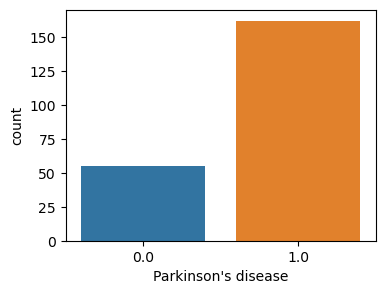

In [24]:
directory_path1 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Archived_users/'
directory_path2 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Tappy_Data/'

data2 = tappyDataset(directory_path1, directory_path2, opt=0)
data2.show_stats()

In [26]:
data2.user_info.tail()

,pID,files,Parkinsons
222,ZT9ASWFCFS,[ZT9ASWFCFS_1606.txt],1.0
223,ZWBPPNQCUX,"[ZWBPPNQCUX_1608.txt, ZWBPPNQCUX_1612.txt]",1.0
224,ZWHGXDUDLG,[ZWHGXDUDLG_1703.txt],1.0
225,ZY9CCHSPF2,"[ZY9CCHSPF2_1607.txt, ZY9CCHSPF2_1608.txt, ZY9...",1.0
226,ZYWLN4JVLA,[ZYWLN4JVLA_1701.txt],1.0


In [4]:
data2.prepare_dataset(directory_path2, feature_extract=2)
# print(data2.trainset.shape)

0


C:\Users\Hanna\AppData\Local\Temp\ipykernel_15052\1568283625.py:51: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, delimiter="\t", index_col=False, header=None, names=[


1
2
3
4
5
Another file was found!
6
7
8
9
10
11
12
13
14
15
16
Another file was found!
17
18
19
20
21
Another file was found!
22
23
24
25
26
27
28
29
Another file was found!
30
31
32
33
Another file was found!
34
35
36
Another file was found!
Warning was raised as an exception!
Warning was raised as an exception!
37
38
39
40
41
42
43
44
Another file was found!
45
46
47
48
49
Another file was found!
Warning was raised as an exception!
Warning was raised as an exception!
50
Another file was found!
51
52
53
54
Another file was found!
55
Another file was found!
56
57


C:\Users\Hanna\AppData\Local\Temp\ipykernel_15052\1568283625.py:51: DtypeWarning: Columns (4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, delimiter="\t", index_col=False, header=None, names=[


58
Another file was found!
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
Another file was found!
87
88
89
90
91
Another file was found!
92
93
94
95
96
97
98
99
100
101
102
Another file was found!
103
104
105
106
107
108
109
110
111
Another file was found!
112
113
Another file was found!
114
115
116
117
Another file was found!
Warning was raised as an exception!
Warning was raised as an exception!
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
Another file was found!
133
Another file was found!
134
Another file was found!
135
136
137
138
Another file was found!
139
140
141
142
143
144
145
146
Another file was found!
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
Warning was raised as an exception!
Warning was raised as an exception!
Another file was found!
166
167
     SUCCESS!!!


In [5]:
print(data2.features.shape)
signiX = data2.features
signiY = data2.user_info['Parkinsons'].to_numpy()

(168, 22)


In [12]:
np.save('data_features.npy', data2.features)
np.save('data_gt.npy', data2.user_info['Parkinsons'].to_numpy())

In [14]:
signiX = np.load('data_features.npy')
signiY = np.load('data_gt.npy')

In [36]:
def sampling_imbalanced_data(X, y, opt='under'):
    if str(opt) == 'under':
        rus = RandomUnderSampler(random_state=None)
        X_resampl, y_resampl = rus.fit_resample(X, y)
    else:
        ros = RandomOverSampler(random_state=None)
        X_resampl, y_resampl = ros.fit_resample(X, y)
    return X_resampl, y_resampl
    

X_resampl, y_resampl = sampling_imbalanced_data(signiX, signiY, opt='under')
trainset, testset, train_ground_truth, test_ground_truth = train_test_split(
    X_resampl, y_resampl, test_size=0.3, shuffle=True, random_state=42)
    # signiX, signiY, test_size=0.3, shuffle=True, random_state=42)

('  KNN')
model = train_kNN_model(trainset, train_ground_truth)
predictions, acc_val, rep = test_selected_model(testset, test_ground_truth, model)

('  SVM')
model = train_SVM_model(trainset, train_ground_truth)
predictions, acc_val, rep = test_selected_model(testset, test_ground_truth, model)

0.3076923076923077
              precision    recall  f1-score   support

         0.0       0.29      0.33      0.31        12
         1.0       0.33      0.29      0.31        14

    accuracy                           0.31        26
   macro avg       0.31      0.31      0.31        26
weighted avg       0.31      0.31      0.31        26

0.4230769230769231
              precision    recall  f1-score   support

         0.0       0.42      0.67      0.52        12
         1.0       0.43      0.21      0.29        14

    accuracy                           0.42        26
   macro avg       0.42      0.44      0.40        26
weighted avg       0.43      0.42      0.39        26

